In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

np.random.seed(42)

In [2]:
n_proteins = 5000
n_samples_per_group = 500
total_samples = n_samples_per_group * 2

In [3]:
# Generate protein IDs
protein_ids = [f'Protein_{i+1}' for i in range(n_proteins)]

In [4]:
data = np.zeros((n_proteins, total_samples))

In [5]:
idx_pval_lt_0_01 = np.arange(0, 100)
idx_pval_0_01_to_0_1 = np.arange(100, 200)
idx_non_significant = np.arange(200, n_proteins)

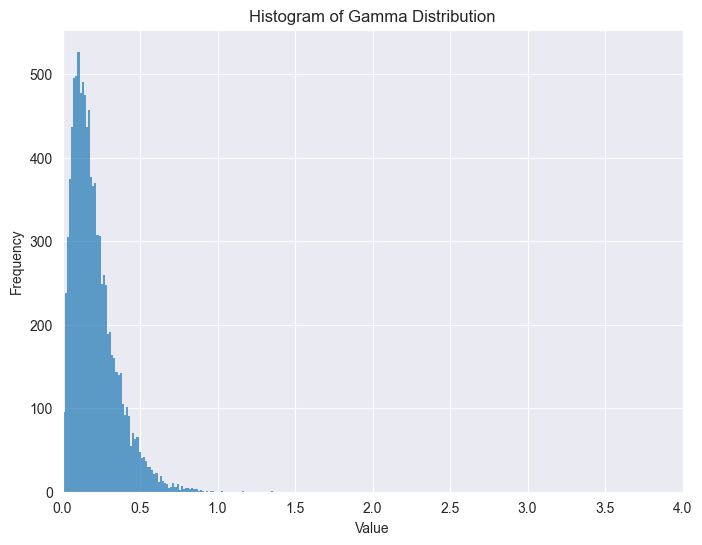

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data from a gamma distribution
shape_k = 2.0    # shape parameter > 1 to move peak away from 0
scale_theta = 0.1  # scale parameter (controls spread)

data = np.random.gamma(shape=shape_k, scale=scale_theta, size=10000)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(data, bins=100, alpha=0.7, edgecolor='none')
plt.xlim(0, 4)
plt.title('Histogram of Gamma Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

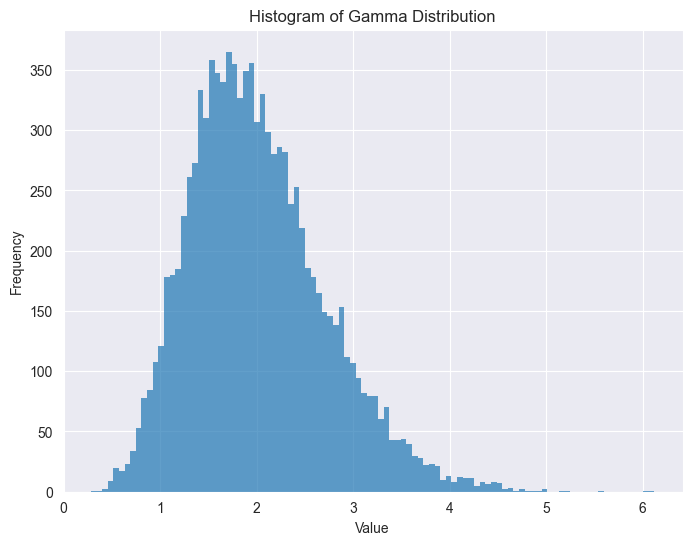

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data from a gamma distribution
shape_k = 8    # shape parameter > 1 to move peak away from 0
scale_theta = 0.25  # scale parameter (controls spread)

data = np.random.gamma(shape=shape_k, scale=scale_theta, size=10000)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(data, bins=100, alpha=0.7, edgecolor='none')

plt.title('Histogram of Gamma Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [8]:
pvals_lt_0_01_counts = 0
pvals_lt_0_01 = []

while pvals_lt_0_01_counts < 100:

    shape_k = 8    # shape parameter > 1 to move peak away from 0
    scale_theta = 0.25
    fc = np.random.gamma(shape=shape_k, scale=scale_theta)
    fc = np.random.normal(2, 0.5)

    loc = np.random.randint(8, 20)

    shape_k = 2.0    # shape parameter > 1 to move peak away from 0
    scale_theta = 0.1  # scale parameter (controls spread)
    scale = np.random.gamma(shape=shape_k, scale=scale_theta)

    group1 = np.random.normal(loc=loc, scale=scale, size=n_samples_per_group)
    group2 = np.random.normal(loc=loc+fc, scale=scale, size=n_samples_per_group)

    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    if (0.0 < p_val <= 0.01) and pvals_lt_0_01_counts < 100:

        if -np.log10(p_val) < 40 and group2.mean() - group1.mean() > 0:

            pvals_lt_0_01.append(np.concatenate([group1, group2]))

            pvals_lt_0_01_counts += 1


In [9]:
pvals_0_01_counts = 0
pvals_0_01_to_0_1 = []

while pvals_0_01_counts < 100:

    fc = np.random.normal(0.0, 0.5)

    loc = np.random.randint(8, 20)

    shape_k = 2.0    # shape parameter > 1 to move peak away from 0
    scale_theta = 0.1  # scale parameter (controls spread)
    scale = np.random.gamma(shape=shape_k, scale=scale_theta)

    group1 = np.random.normal(loc=loc, scale=scale, size=n_samples_per_group)
    group2 = np.random.normal(loc=loc+fc, scale=scale, size=n_samples_per_group)

    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    if p_val > 0.01 and pvals_0_01_counts < 100:

        pvals_0_01_to_0_1.append(np.concatenate([group1, group2]))
        pvals_0_01_counts += 1


In [10]:
num_pval_gt_0_1 = 0

pvals_gt_0_1 = []

while num_pval_gt_0_1 < n_proteins - 200:

    fc = np.random.normal(0, 0.5)

    loc = np.random.randint(8, 20)

    shape_k = 2.0    # shape parameter > 1 to move peak away from 0
    scale_theta = 0.1  # scale parameter (controls spread)
    scale = np.random.gamma(shape=shape_k, scale=scale_theta)

    group1 = np.random.normal(loc=loc, scale=scale, size=n_samples_per_group)
    group2 = np.random.normal(loc=loc+fc, scale=scale, size=n_samples_per_group)

    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    if p_val > 0.01:

        pvals_gt_0_1.append(np.concatenate([group1, group2]))

        num_pval_gt_0_1 += 1



In [11]:
data = np.concatenate(
    [
        pvals_lt_0_01,
        pvals_0_01_to_0_1,
        pvals_gt_0_1,
    ]
)

In [12]:
data

array([[10.14258148,  9.91448125, 11.08235873, ...,  9.91630875,
         9.65543791, 10.55578213],
       [16.8514186 , 17.07972941, 17.00737852, ..., 17.31159483,
        16.93258008, 16.89292357],
       [ 8.74827668,  9.32851764,  9.14832183, ...,  9.06408633,
         8.77289403,  9.95907766],
       ...,
       [12.35418135, 11.68026659, 12.03466644, ..., 12.32600914,
        12.44196912, 11.51297096],
       [16.18859594, 15.94877871, 15.62885679, ..., 15.56679893,
        15.92952884, 16.30447773],
       [ 8.90036931,  9.04326378,  9.22281911, ...,  8.66543625,
         9.40623195,  8.95010901]])

In [13]:
samples = [f'Sample_{i+1}' for i in range(total_samples)]
df = pd.DataFrame(data, index=protein_ids, columns=samples)
df = df.reset_index(names="Protein")

In [14]:
group_labels = ['Group1'] * n_samples_per_group + ['Group2'] * n_samples_per_group

In [15]:
design_matrix = pd.DataFrame(
    {
        "sample": samples,
        "group": group_labels,
    }
)

In [16]:
design_matrix.to_csv(
    "../tests/input_files/simulated_design_matrix.tsv",
    sep="\t",
    index=False,
)

In [17]:
df.to_csv(
    "../tests/input_files/simulated_proteins.tsv",
    sep="\t",
    index=False,
)

In [18]:
from dpks.quant_matrix import QuantMatrix

quant_matrix = QuantMatrix(
    quantification_file=df,
    design_matrix_file=design_matrix,
)

In [19]:
quant_matrix = quant_matrix.compare(
    method="anova",
    comparisons=("Group2", "Group1"),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh",
)

In [20]:
da_df = quant_matrix.row_annotations

In [34]:
da_df[da_df['CorrectedPValueGroup2-Group1'] <= 0.01]

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1,ProteinNum,DAType
0,Protein_1,0.611962,10.325277,10.005668,0.513933,0.537900,0.319609,6.384266e-21,500,500,4.757379e-19,18.322632,1,1
2,Protein_3,0.996976,9.361219,9.041304,0.370667,0.379646,0.319915,4.097088e-38,500,500,1.544287e-35,34.811272,3,1
3,Protein_4,1.154303,10.576409,10.036481,0.613543,0.609071,0.539928,1.523415e-40,500,500,3.732366e-37,36.428016,4,1
4,Protein_5,0.483148,12.037911,12.000647,0.063359,0.062550,0.037264,5.610459e-20,500,500,3.984239e-18,17.399655,5,1
5,Protein_6,0.824455,12.270897,12.005789,0.341127,0.349872,0.265107,1.233188e-31,500,500,1.731856e-29,28.761488,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Protein_96,0.807161,19.426380,19.001658,0.614001,0.589699,0.424722,2.868369e-27,500,500,2.811002e-25,24.551139,96,1
96,Protein_97,1.000714,15.402200,15.027102,0.450689,0.439816,0.375097,2.630424e-37,500,500,6.783726e-35,34.168532,97,1
97,Protein_98,0.613941,15.481397,15.021018,0.927862,0.896270,0.460379,4.254563e-15,500,500,2.672738e-13,12.573044,98,1
98,Protein_99,1.173631,16.641785,15.986313,0.739159,0.796752,0.655472,3.923322e-38,500,500,1.544287e-35,34.811272,99,1


In [22]:
da_df[da_df['Protein'] == "Protein_101"]

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1
100,Protein_101,0.069667,9.066842,9.003485,0.988839,0.982793,0.063357,0.310279,500,500,0.50144,0.299781


In [23]:
da_df.sort_values(by="CorrectedPValueGroup2-Group1", ascending=True)

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1
3,Protein_4,1.154303,10.576409,10.036481,0.613543,0.609071,0.539928,1.523415e-40,500,500,3.732366e-37,36.428016
12,Protein_13,1.139273,15.483100,14.978225,0.568973,0.571593,0.504875,1.037110e-40,500,500,3.732366e-37,36.428016
69,Protein_70,1.160372,18.517229,17.942873,0.674751,0.636813,0.574356,6.395071e-40,500,500,7.833962e-37,36.106019
81,Protein_82,1.225558,18.699991,18.020877,0.785121,0.765264,0.679115,5.810516e-40,500,500,7.833962e-37,36.106019
76,Protein_77,1.016863,11.303399,11.001916,0.354227,0.341171,0.301483,3.068402e-39,500,500,3.007034e-36,35.521862
...,...,...,...,...,...,...,...,...,...,...,...,...
510,Protein_511,0.000098,11.001375,11.001288,0.449039,0.416405,0.000087,9.974653e-01,500,500,9.782987e-01,0.009529
3822,Protein_3823,0.000027,13.998638,13.998655,0.116393,0.120351,-0.000017,9.982160e-01,500,500,9.788389e-01,0.009289
1665,Protein_1666,0.000063,15.020384,15.020442,0.681027,0.668433,-0.000057,9.989273e-01,500,500,9.793405e-01,0.009066
220,Protein_221,0.000036,15.000559,15.000591,0.475928,0.450171,-0.000032,9.991376e-01,500,500,9.793508e-01,0.009062


In [24]:
da_df['ProteinNum'] = da_df['Protein'].str.split("_").str[-1].astype(int)

In [25]:
da_df['DAType'] = np.where(da_df['ProteinNum'] <= 100, 1, np.where(da_df['ProteinNum'] < 200, 2, 0))

<Axes: xlabel='Log2FoldChangeGroup2-Group1', ylabel='-Log10CorrectedPValueGroup2-Group1'>

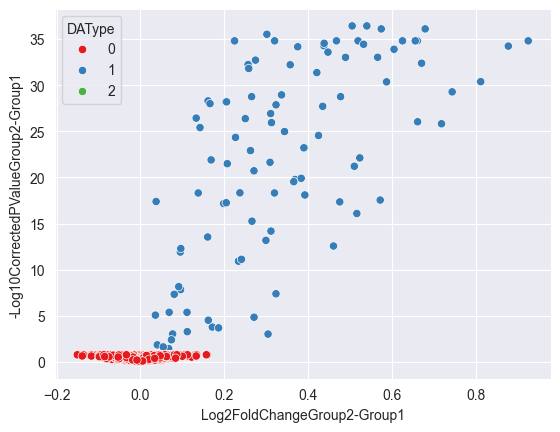

In [26]:
sns.scatterplot(
    data=da_df,
    x="Log2FoldChangeGroup2-Group1",
    y="-Log10CorrectedPValueGroup2-Group1",
    hue="DAType",
    palette="Set1",
)

In [27]:
da_df

,Protein,DEScoreGroup2-Group1,GroupGroup2Mean,GroupGroup1Mean,GroupGroup2Stdev,GroupGroup1Stdev,Log2FoldChangeGroup2-Group1,PValueGroup2-Group1,GroupGroup2RepCounts,GroupGroup1RepCounts,CorrectedPValueGroup2-Group1,-Log10CorrectedPValueGroup2-Group1,ProteinNum,DAType
0,Protein_1,0.611962,10.325277,10.005668,0.513933,0.537900,0.319609,6.384266e-21,500,500,4.757379e-19,18.322632,1,1
1,Protein_2,0.098939,17.063754,17.023624,0.180206,0.167111,0.040131,2.784064e-04,500,500,1.392032e-02,1.856351,2,1
2,Protein_3,0.996976,9.361219,9.041304,0.370667,0.379646,0.319915,4.097088e-38,500,500,1.544287e-35,34.811272,3,1
3,Protein_4,1.154303,10.576409,10.036481,0.613543,0.609071,0.539928,1.523415e-40,500,500,3.732366e-37,36.428016,4,1
4,Protein_5,0.483148,12.037911,12.000647,0.063359,0.062550,0.037264,5.610459e-20,500,500,3.984239e-18,17.399655,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Protein_4996,0.006940,19.007756,19.002782,0.182253,0.183738,0.004974,6.677570e-01,500,500,7.901496e-01,0.102291,4996,0
4996,Protein_4997,0.007280,9.007188,9.002031,0.181856,0.176919,0.005157,6.498759e-01,500,500,7.766810e-01,0.109757,4997,0
4997,Protein_4998,0.040362,12.077672,12.043749,0.429630,0.428220,0.033922,2.118773e-01,500,500,4.024026e-01,0.395339,4998,0
4998,Protein_4999,0.054933,15.962653,15.996203,0.231676,0.231787,-0.033550,2.241142e-02,500,500,1.646317e-01,0.783487,4999,0


In [28]:
quant_matrix.quantitative_data.X

array([[10.14258148,  9.91448125, 11.08235873, ...,  9.91630875,
         9.65543791, 10.55578213],
       [16.8514186 , 17.07972941, 17.00737852, ..., 17.31159483,
        16.93258008, 16.89292357],
       [ 8.74827668,  9.32851764,  9.14832183, ...,  9.06408633,
         8.77289403,  9.95907766],
       ...,
       [12.35418135, 11.68026659, 12.03466644, ..., 12.32600914,
        12.44196912, 11.51297096],
       [16.18859594, 15.94877871, 15.62885679, ..., 15.56679893,
        15.92952884, 16.30447773],
       [ 8.90036931,  9.04326378,  9.22281911, ...,  8.66543625,
         9.40623195,  8.95010901]])

<Axes: xlabel='Log2FoldChangeGroup2-Group1', ylabel='Count'>

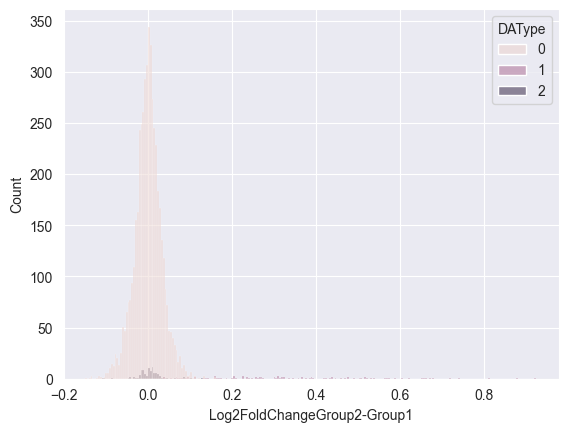

In [36]:
sns.histplot(
    data=da_df,
    x="Log2FoldChangeGroup2-Group1",
    hue="DAType",
)